In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

In [4]:
dim = 2
alpha = 1. / 16.
sigma = 0.1
T = 4.0
dt = 1. / 100
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)

In [5]:
wiener_process = WienerProcess(dim=dim, dtype=dtype, T=T, dt=dt)
cell_proc = CellDiffusionProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)
cell_aux_proc = CellDiffusionAuxProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)

L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
cell_guided_bridge_proc = GuidedBridgeProcess(L0=L0, Sigma0=Sigma0, ori_proc=cell_proc, aux_proc=cell_aux_proc, x0=x0, xT=xT)

In [6]:
from flax import linen as nn
from flax.training import train_state
import optax

In [7]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(2)(x)
        return x

In [13]:
def train_model(rng_key, model, path_solver, n_epochs, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 2))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.adam(1e-3)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs = path.ts, path.xs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs
    
    def compute_loss(state, params, ts, xs):
        nus = state.apply_fn(params, ts, xs)
        Gs = jax.vmap(jax.vmap(cell_guided_bridge_proc.G))(ts, xs)
        # scaling = p_tilde(t=0, x=x0) / p(t=0, x=x0)
        scaling = 1.0
        Gs = scaling * jnp.sum(Gs, axis=1) * dt
        return 0.5 * jnp.mean(Gs * (jnp.sum(jnp.linalg.norm(nus, axis=-1)**2, axis=1) * dt))
    
    # @jax.jit
    def train_step(state, ts, xs):
        grad_fn = jax.value_and_grad(compute_loss, argnums=1, has_aux=False)
        loss, grads = grad_fn(state, state.params, ts, xs)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    losses = []
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        ts, xs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs)
        losses.append(loss)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state, losses

In [14]:
key = jax.random.PRNGKey(42)
wiener_process = WienerProcess(dim=dim, dtype=dtype)

cell_guided_bridge_solver = Euler(cell_guided_bridge_proc, wiener_process)

In [15]:
model = MLP()
n_epochs = 1000
batch_size = 32

In [16]:
model_state, losses = train_model(key, model, cell_guided_bridge_solver, n_epochs, batch_size)

Epoch 100, loss: 0.01868491619825363
Epoch 200, loss: 0.013290231116116047
Epoch 300, loss: 0.013739602640271187
Epoch 400, loss: 0.006015576422214508
Epoch 500, loss: 0.005944284610450268
Epoch 600, loss: 0.0029641701839864254
Epoch 700, loss: 0.0024680420756340027
Epoch 800, loss: 0.0015298532089218497
Epoch 900, loss: 0.0012866044417023659
Epoch 1000, loss: 0.001017569680698216


In [17]:
def nu_learned(t, x):
    return model_state.apply_fn(model_state.params, t, x)

In [18]:
nu_learned(0.0, x0)

Array([0.00118556, 0.00043824], dtype=float32)

In [22]:
cell_mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=cell_proc,
    aux_proc=cell_aux_proc,
    nu=nu_learned,
    xT=xT,
    x0=x0,
    L0=L0,
    Sigma0=Sigma0
)

cell_mixed_bridge_solver = Euler(cell_mixed_bridge_proc, wiener_process)
cell_mixed_bridge_path = cell_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)
cell_guided_bridge_path = cell_guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)

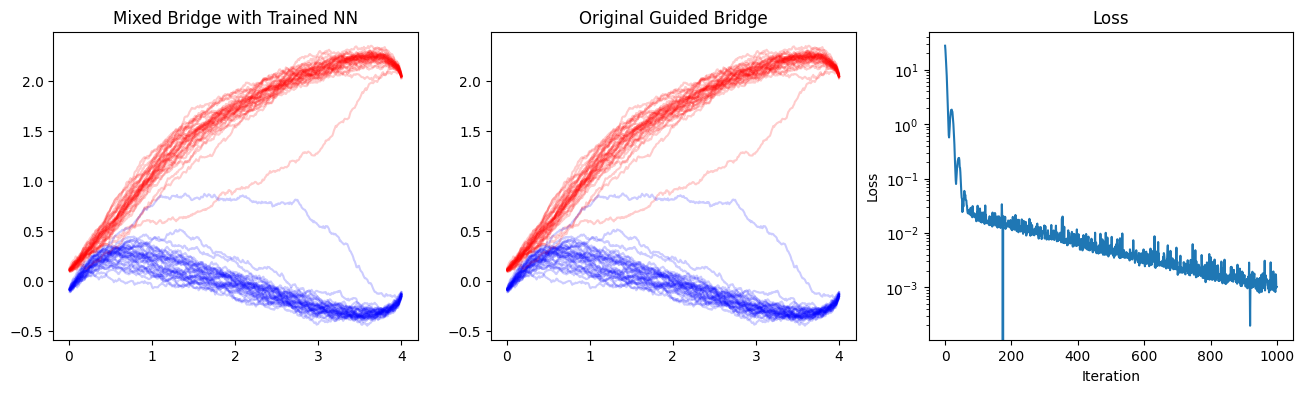

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(32):
    axs[0].plot(cell_mixed_bridge_path.ts, cell_mixed_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[0].plot(cell_mixed_bridge_path.ts, cell_mixed_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
    axs[1].plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    axs[1].plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)
axs[2].plot(losses)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Loss")
axs[2].set_yscale("log")
axs[0].set_title("Mixed Bridge with Trained NN")
axs[1].set_title("Original Guided Bridge")
axs[2].set_title("Loss")

plt.show()

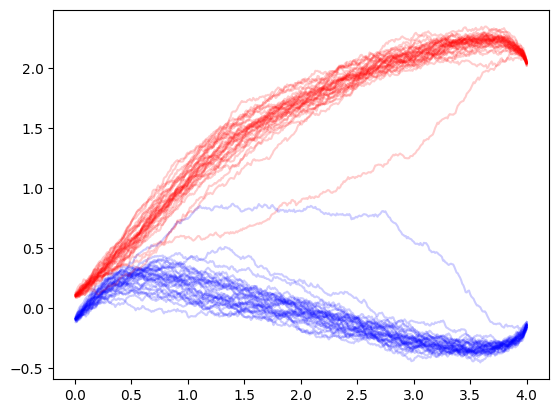

In [21]:
cell_guided_bridge_path = cell_guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=32)
for i in range(32):
    plt.plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    plt.plot(cell_guided_bridge_path.ts, cell_guided_bridge_path.xs[i, :, 1], color="blue", alpha=0.2)

plt.show()